In [791]:
!pip install p3_data

In [792]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [793]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [794]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

## attempt4 broker out of direct memory - 52 tests
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# Pravega 0.8.0-2577.15b0f5eb9 tier2
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 94 files...


In [795]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [796]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [797]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [798]:
# Show list of columns
clean_df.columns.values

array(['ackQuorum', 'aggregatedEndToEndLatency50pct',
       'aggregatedEndToEndLatency75pct', 'aggregatedEndToEndLatency95pct',
       'aggregatedEndToEndLatency9999pct',
       'aggregatedEndToEndLatency999pct',
       'aggregatedEndToEndLatency99pct', 'aggregatedEndToEndLatencyAvg',
       'aggregatedEndToEndLatencyMax',
       'aggregatedEndToEndLatencyQuantiles',
       'aggregatedPublishLatency50pct', 'aggregatedPublishLatency75pct',
       'aggregatedPublishLatency95pct', 'aggregatedPublishLatency9999pct',
       'aggregatedPublishLatency999pct', 'aggregatedPublishLatency99pct',
       'aggregatedPublishLatencyAvg', 'aggregatedPublishLatencyMax',
       'aggregatedPublishLatencyQuantiles', 'ansible', 'ansible_vars',
       'aws-ec2', 'backlog', 'bookkeeperVersion', 'build',
       'command_timed_out', 'consumeRate', 'consumeRateEventsPerSecMean',
       'consumeRateMBPerSecMean', 'consumeRateMean',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'deduplicationE

In [799]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [800]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [801]:
cols = param_cols + output_cols

In [802]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,4c11c134-0781-41fe-bb0b-2783e9b1ced0,6ca3578b-ef05-496f-9dba-8bdaf9a06572,43d240fd-8117-498d-9ca2-96cc1f46b96f,65e3093f-f306-4e59-b13d-5bedca1f66c4,af297422-111b-409a-a555-ef348a11aa39,5e2414b0-ac02-4994-875f-4395b3c1be8a,9b000165-1f42-456d-b11c-b1349bc383c6,6f007697-b1c2-4be4-83b7-c8ebeea3c4dd,d9a5ac60-8d7f-4887-8047-5d3643575efa,b7a579a9-d269-4da7-8af7-dd469befc293,...,2ef3bc25-711f-4133-a401-4c55c695593a,375d77ea-c7a2-4e38-b790-23c40ad820a7,dc561f62-b216-4a1b-8a5b-d8b01e85f62f,c656f356-ab2a-4503-9fe9-e312bb964167,0465f2a4-d1ce-454e-84ef-c5942c0d2518,1eaac064-5316-4dc3-aefd-e313bfee091d,d75c5695-cfc2-4228-b93a-d26e0721fd03,f85b9644-4727-443e-b73f-b90a0c78cf7d,0c7bf359-7f2a-4d66-9be6-5f807d9c930c,4946d516-9dd4-46a4-b83e-2719f2050284
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,16,16,16,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,...,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86,88dbf86
driverName,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,...,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega


In [803]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [804]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [805]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
0.8.0-2656.1c40f1e-Isilon-tier2    48
2.6.0-ecs-s3-tier2                 46
dtype: int64

In [806]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

48

In [807]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [808]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [809]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [810]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [811]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [812]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [813]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [814]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=16,
    topics=4
)

In [815]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [816]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,fade061e-9448-4a6a-b264-cfd6fddf29d7
numWorkloadWorkers,4
topics,4
partitionsPerTopic,16
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,88dbf86
driverName,Pravega


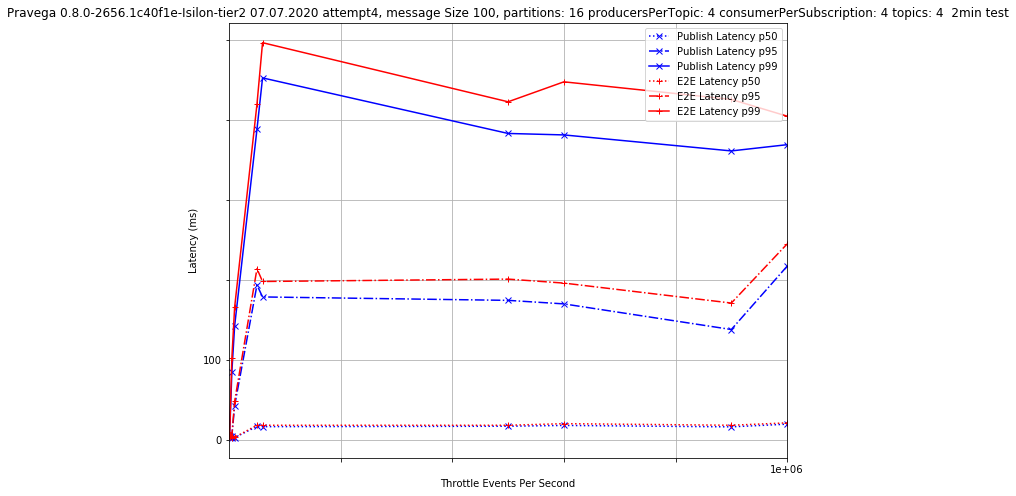

In [817]:
plot_latency_vs_provided_rate_normal(filt_100_df)

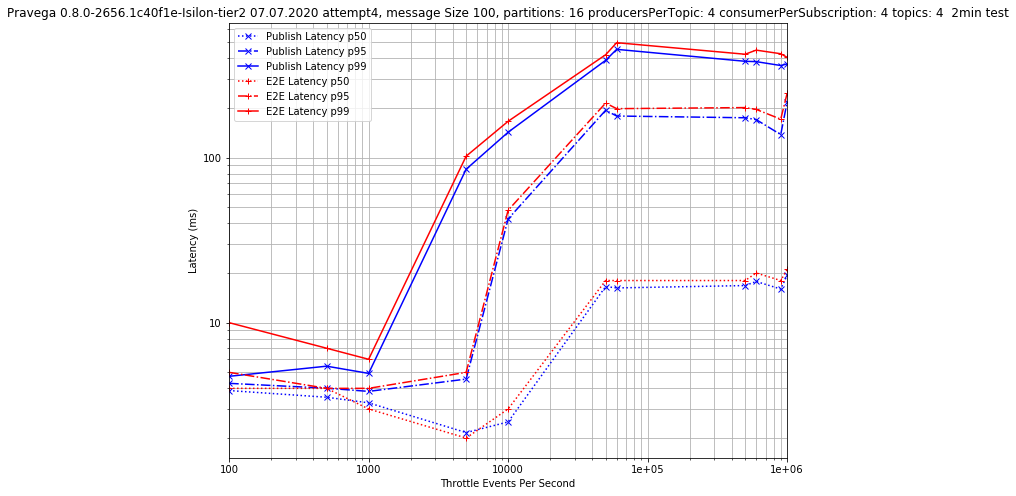

In [818]:
plot_latency_vs_provided_rate(filt_100_df)

In [819]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.879,4.289,4.732,4.0,5.0,10.000,e50112e5-d21b-4b5e-84e2-cb1d2341b3a8
500.0,3.533,4.009,5.450,4.0,4.0,7.000,65cc7000-3a68-463c-9262-f19949075e76
1000.0,3.268,3.834,4.928,3.0,4.0,6.000,ef634999-d955-485f-96b3-d40930fbedc6
5000.0,2.158,4.552,85.041,2.0,5.0,102.000,a4c859b1-95cd-49c2-b6e7-04f8d5d5dea7
10000.0,2.504,42.483,142.535,3.0,48.0,166.000,cabba55b-c6af-44de-9323-c2918ec5ac4b
50000.0,16.549,193.586,388.551,18.0,214.0,420.001,d53de8cc-1b00-4c64-9737-cd7b670beee6
60000.0,16.238,178.658,452.919,18.0,198.0,497.001,d3eff886-a12e-4aff-90a2-8039a4129f27
500000.0,16.779,174.373,383.351,18.0,201.0,423.001,477f270a-58ec-4179-8f12-2608daa4946a
600000.0,17.766,169.955,381.525,20.0,196.0,448.001,75b51f64-1d0b-4bf0-9582-df28da7e0bc5


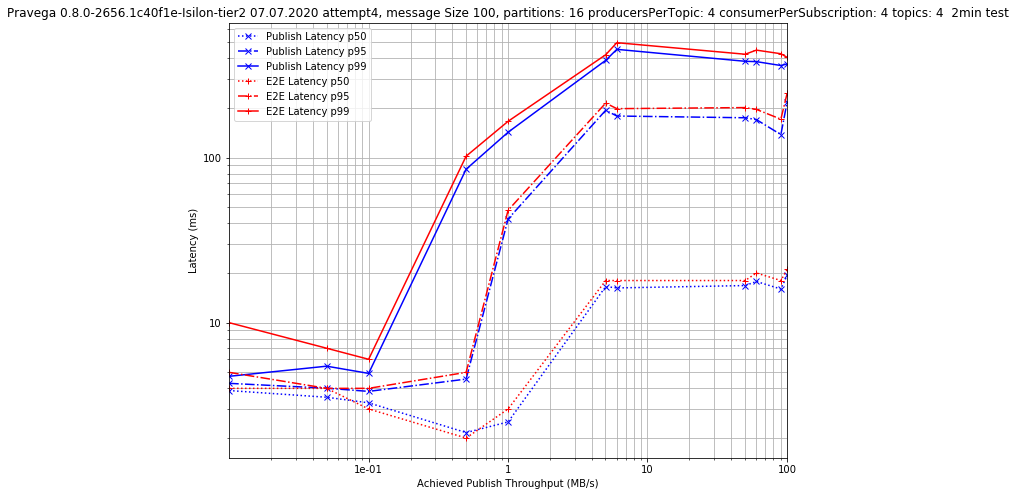

In [820]:
plot_latency_vs_publish_throughput(filt_100_df)

In [821]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010015,3.879,4.289,4.732,4.0,5.0,10.000,e50112e5-d21b-4b5e-84e2-cb1d2341b3a8
0.050093,3.533,4.009,5.450,4.0,4.0,7.000,65cc7000-3a68-463c-9262-f19949075e76
0.100187,3.268,3.834,4.928,3.0,4.0,6.000,ef634999-d955-485f-96b3-d40930fbedc6
0.500770,2.158,4.552,85.041,2.0,5.0,102.000,a4c859b1-95cd-49c2-b6e7-04f8d5d5dea7
1.001745,2.504,42.483,142.535,3.0,48.0,166.000,cabba55b-c6af-44de-9323-c2918ec5ac4b
5.016518,16.549,193.586,388.551,18.0,214.0,420.001,d53de8cc-1b00-4c64-9737-cd7b670beee6
6.030269,16.238,178.658,452.919,18.0,198.0,497.001,d3eff886-a12e-4aff-90a2-8039a4129f27
50.144152,16.779,174.373,383.351,18.0,201.0,423.001,477f270a-58ec-4179-8f12-2608daa4946a
60.347471,17.766,169.955,381.525,20.0,196.0,448.001,75b51f64-1d0b-4bf0-9582-df28da7e0bc5


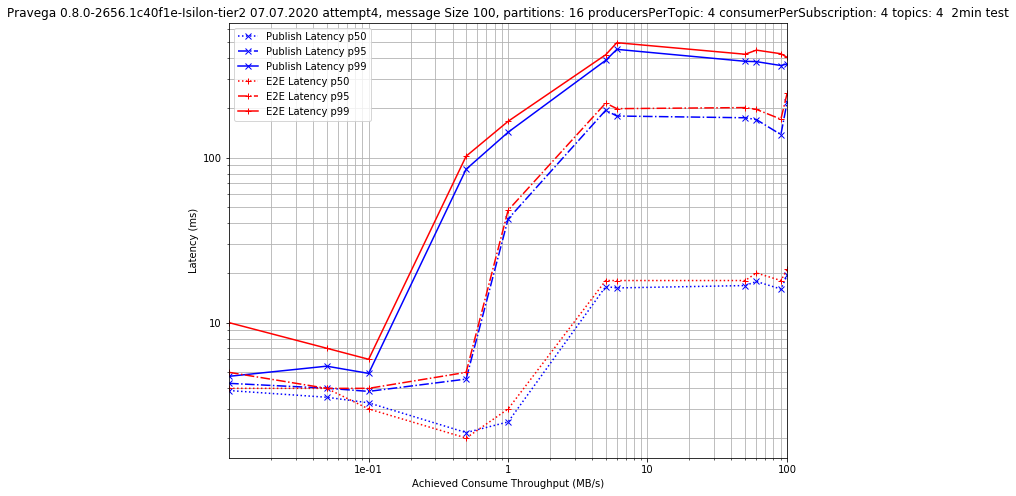

In [822]:
plot_latency_vs_consume_throughput(filt_100_df)

In [823]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.010008,3.879,4.289,4.732,4.0,5.0,10.000,e50112e5-d21b-4b5e-84e2-cb1d2341b3a8
0.050086,3.533,4.009,5.450,4.0,4.0,7.000,65cc7000-3a68-463c-9262-f19949075e76
0.100183,3.268,3.834,4.928,3.0,4.0,6.000,ef634999-d955-485f-96b3-d40930fbedc6
0.500773,2.158,4.552,85.041,2.0,5.0,102.000,a4c859b1-95cd-49c2-b6e7-04f8d5d5dea7
1.001752,2.504,42.483,142.535,3.0,48.0,166.000,cabba55b-c6af-44de-9323-c2918ec5ac4b
5.016235,16.549,193.586,388.551,18.0,214.0,420.001,d53de8cc-1b00-4c64-9737-cd7b670beee6
6.030459,16.238,178.658,452.919,18.0,198.0,497.001,d3eff886-a12e-4aff-90a2-8039a4129f27
50.105557,16.779,174.373,383.351,18.0,201.0,423.001,477f270a-58ec-4179-8f12-2608daa4946a
60.351949,17.766,169.955,381.525,20.0,196.0,448.001,75b51f64-1d0b-4bf0-9582-df28da7e0bc5


## Message Size 10 KB

In [824]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
)

In [825]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,65e3093f-f306-4e59-b13d-5bedca1f66c4
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,88dbf86
driverName,Pravega


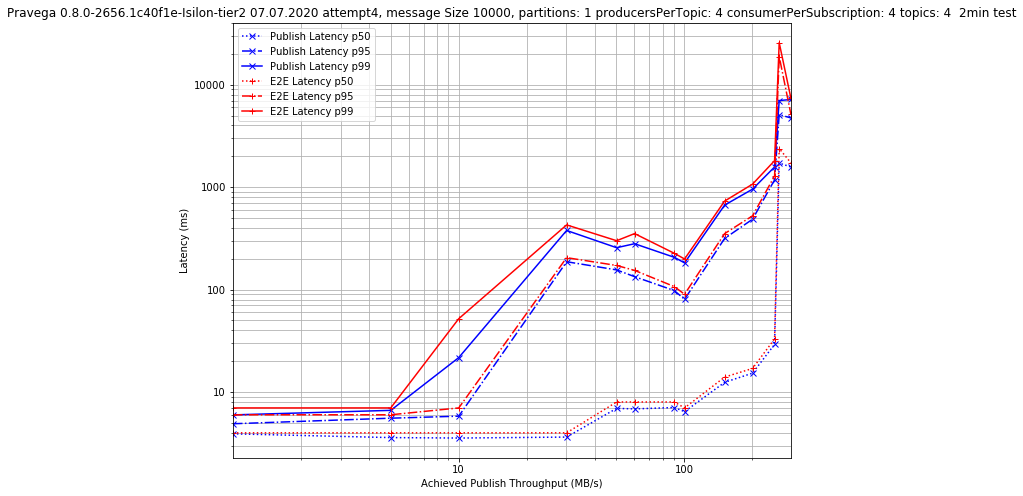

In [826]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [827]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
1.001515,3.910,4.903,5.985,4.000,6.000,7.000,65e3093f-f306-4e59-b13d-5bedca1f66c4
5.006539,3.594,5.558,6.628,4.000,6.000,7.000,af297422-111b-409a-a555-ef348a11aa39
10.015531,3.558,5.816,21.689,4.000,7.000,52.000,5e2414b0-ac02-4994-875f-4395b3c1be8a
30.092739,3.635,187.099,377.637,4.000,205.000,428.001,d9a5ac60-8d7f-4887-8047-5d3643575efa
50.101029,6.929,155.664,256.434,8.000,172.000,300.001,b7a579a9-d269-4da7-8af7-dd469befc293
60.161338,6.848,133.770,280.339,8.000,154.000,352.001,6f007697-b1c2-4be4-83b7-c8ebeea3c4dd
90.238357,7.064,97.775,206.566,8.000,107.000,226.000,bdcbe324-cb88-44e4-9e06-91e0e8cbf0e6
100.164253,6.439,80.434,182.162,7.000,90.000,199.000,9b000165-1f42-456d-b11c-b1349bc383c6
150.694232,12.441,315.687,667.987,14.000,352.001,731.003,f2847089-6101-46eb-82b9-b63d390f1ac9


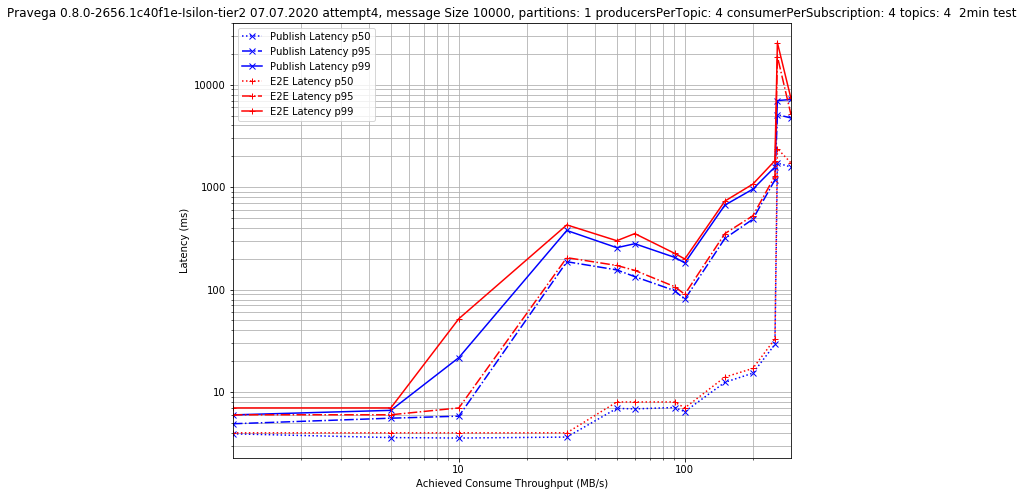

In [828]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [829]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
1.001516,3.910,4.903,5.985,4.000,6.000,7.000,65e3093f-f306-4e59-b13d-5bedca1f66c4
5.006538,3.594,5.558,6.628,4.000,6.000,7.000,af297422-111b-409a-a555-ef348a11aa39
10.015861,3.558,5.816,21.689,4.000,7.000,52.000,5e2414b0-ac02-4994-875f-4395b3c1be8a
30.093313,3.635,187.099,377.637,4.000,205.000,428.001,d9a5ac60-8d7f-4887-8047-5d3643575efa
50.101037,6.929,155.664,256.434,8.000,172.000,300.001,b7a579a9-d269-4da7-8af7-dd469befc293
60.160076,6.848,133.770,280.339,8.000,154.000,352.001,6f007697-b1c2-4be4-83b7-c8ebeea3c4dd
90.241660,7.064,97.775,206.566,8.000,107.000,226.000,bdcbe324-cb88-44e4-9e06-91e0e8cbf0e6
100.162190,6.439,80.434,182.162,7.000,90.000,199.000,9b000165-1f42-456d-b11c-b1349bc383c6
150.688942,12.441,315.687,667.987,14.000,352.001,731.003,f2847089-6101-46eb-82b9-b63d390f1ac9


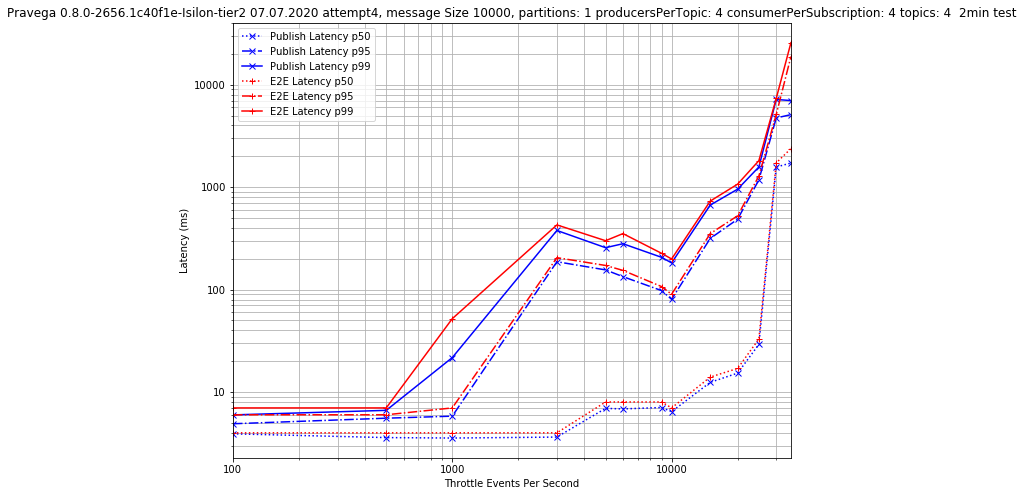

In [830]:
plot_latency_vs_provided_rate(filt_10000_df)

In [831]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.910,4.903,5.985,4.000,6.000,7.000,65e3093f-f306-4e59-b13d-5bedca1f66c4
500.0,3.594,5.558,6.628,4.000,6.000,7.000,af297422-111b-409a-a555-ef348a11aa39
1000.0,3.558,5.816,21.689,4.000,7.000,52.000,5e2414b0-ac02-4994-875f-4395b3c1be8a
3000.0,3.635,187.099,377.637,4.000,205.000,428.001,d9a5ac60-8d7f-4887-8047-5d3643575efa
5000.0,6.929,155.664,256.434,8.000,172.000,300.001,b7a579a9-d269-4da7-8af7-dd469befc293
6000.0,6.848,133.770,280.339,8.000,154.000,352.001,6f007697-b1c2-4be4-83b7-c8ebeea3c4dd
9000.0,7.064,97.775,206.566,8.000,107.000,226.000,bdcbe324-cb88-44e4-9e06-91e0e8cbf0e6
10000.0,6.439,80.434,182.162,7.000,90.000,199.000,9b000165-1f42-456d-b11c-b1349bc383c6
15000.0,12.441,315.687,667.987,14.000,352.001,731.003,f2847089-6101-46eb-82b9-b63d390f1ac9


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [832]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [833]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [834]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [835]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

NameError: name 'test_uuid' is not defined

In [836]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

NameError: name 't' is not defined

In [837]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

NameError: name 'pubcdf' is not defined

NameError: name 'pubpdf' is not defined

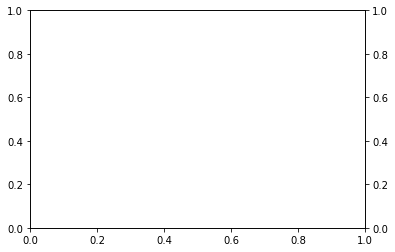

In [838]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [839]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

NameError: name 't' is not defined

NameError: name 'e2epdf' is not defined

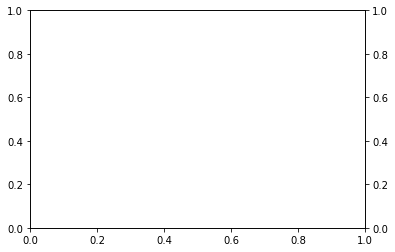

In [840]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [880]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=1,    
)
len(filt_df)

21

In [881]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

11

In [882]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    version='2.6.0-ecs-s3-tier2',
)
len(filt2_df)

10

In [883]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,driverName,version
test_uuid,,,
3ba790ab-8c78-4dab-9a46-457d79b2dac8,88dbf86,Pravega,0.8.0-2656.1c40f1e-Isilon-tier2
80de7cae-6d07-45ef-be61-158a3af02db6,9de924e,Pulsar,2.6.0-ecs-s3-tier2


In [889]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        messageSize = df.messageSize.iloc[0]
        partitionsPerTopic = df.partitionsPerTopic.iloc[0]
        testDurationMinutes = df.testDurationMinutes.iloc[0]
        topics = df.topics.iloc[0]
        producersPerTopic = df.producersPerTopic.iloc[0]
        consumerPerSubscription = df.consumerPerSubscription.iloc[0]
        plot_df = latency_vs_provided_rate_table(df)
        title = 'Compare Pravega lipsky no_netty 1c40f1e Isilon nfs tier2 and Pulsar 2.6.0 ECS s3 tier2 [messageSize %db, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %dmin test' % (messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)

        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [890]:
def plot_latency_vs_consume_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['consumeRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        messageSize = df.messageSize.iloc[0]
        partitionsPerTopic = df.partitionsPerTopic.iloc[0]
        testDurationMinutes = df.testDurationMinutes.iloc[0]
        topics = df.topics.iloc[0]
        producersPerTopic = df.producersPerTopic.iloc[0]
        consumerPerSubscription = df.consumerPerSubscription.iloc[0]
        plot_df = latency_vs_provided_rate_table(df)
        title = 'Compare Pravega lipsky no_netty 1c40f1e Isilon nfs tier2 and Pulsar 2.6.0 ECS s3 tier2 [messageSize %db, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %dmin test' % (messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)

        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Consume Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

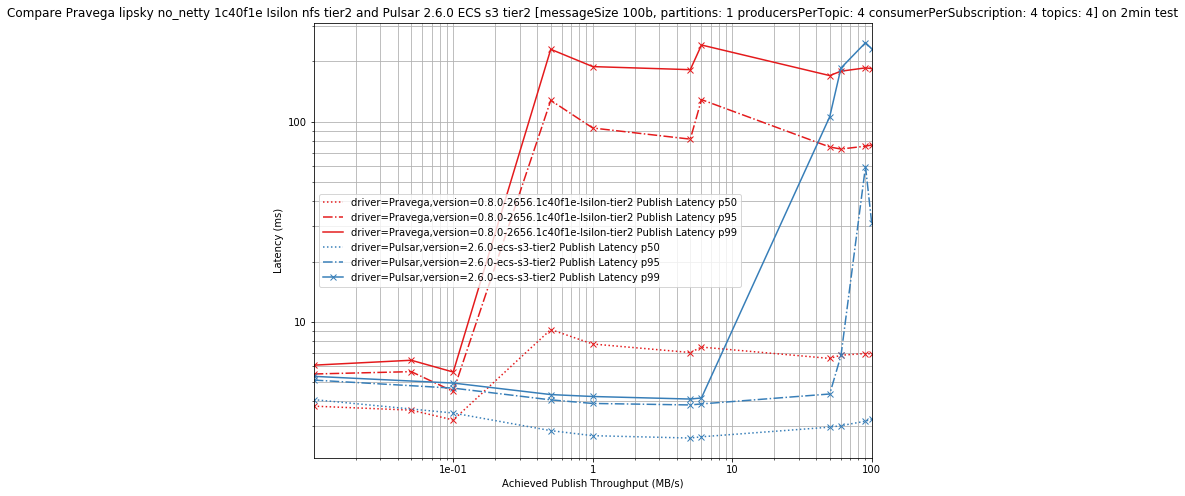

In [891]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

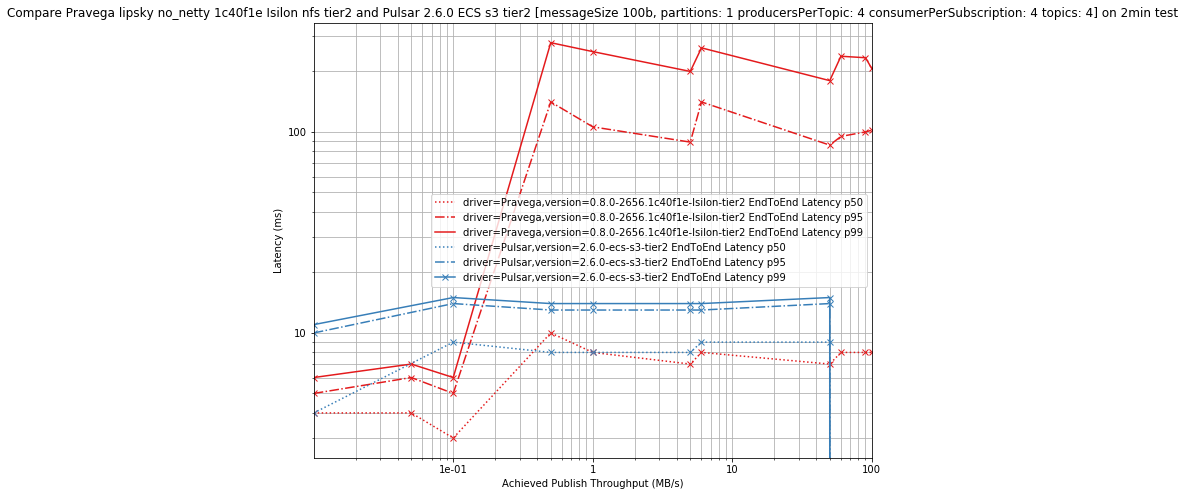

In [892]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')